In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import  os # data 

# Image processing
from PIL import Image, ImageFile
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Plotting
# %matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
path, dirs, files = next(os.walk("./boats"))
dirs

['buoy',
 'cruise ship',
 'ferry boat',
 'freight boat',
 'gondola',
 'inflatable boat',
 'kayak',
 'paper boat',
 'sailboat']

In [25]:
boat_types = ['cruise ship', 'gondola', 'kayak', 'sailboat', 'ferry boat', 'buoy', 'freight boat', 'inflatable boat', 'paper boat',] 

In [26]:
import glob

i = 0

X_data = []
Y_data = []

for boat in boat_types:
    print(boat)
    files = glob.glob ("./boats/" + str(boat) + "/*.jpg")
    
    for myFile in files:
      img = Image.open(myFile)
      #img.thumbnail((width, height), Image.ANTIALIAS) # resizes image in-place keeps ratio
      img = img.resize((128,128), Image.ANTIALIAS) # resizes image without ratio
      img = np.array(img)

      if img.shape == (128, 128, 3):
        # Add the numpy image to matrix with all data
        X_data.append (img)
        Y_data.append (i)
        
    i += 1
print("Converting the lists to numpy arrays and make the output categorical")

cruise ship
gondola
kayak
sailboat
ferry boat
buoy
freight boat
inflatable boat
paper boat
Converting the lists to numpy arrays and make the output categorical


In [28]:
X = np.array(X_data)
Y = np.array(Y_data)
# Print shapes to see if they are correct
print(X.shape)
print(Y.shape)

(1460, 128, 128, 3)
(1460,)


In [29]:
from keras.utils.np_utils import to_categorical
X = X.astype('float32') / 255.0
y_cat = to_categorical(Y_data, len(boat_types))

In [30]:
boats = []
number_of_boats = []

path, dirs, files = next(os.walk("./boats"))  

for dir in dirs:
  path2, dirs2, files2 = next(os.walk("./boats/" + dir))  
  boats.append(dir)
  number_of_boats.append(len(files2))

 
df = pd.DataFrame({'Boat Types':boats, 'N':number_of_boats})
df = df.sort_values(['N'], ascending=False)

df_actual = df.set_index('Boat Types')
df_actual = df_actual.loc[boat_types]
df_actual = df_actual.sort_values(['N'], ascending=False)

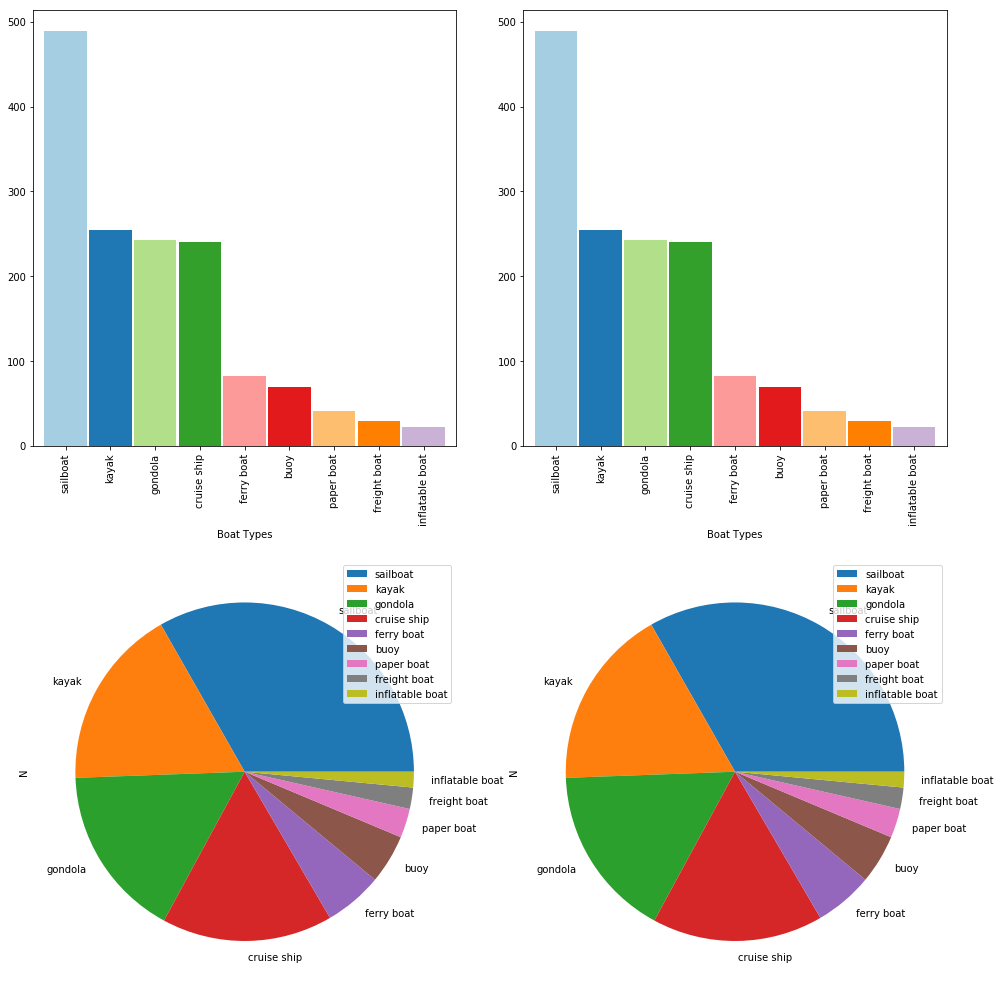

In [31]:
fig, axes = plt.subplots(2,2, figsize=(14,14))  # 1 row, 2 columns
df.plot('Boat Types', ax=axes[0,0], kind='bar', legend=False, color=[plt.cm.Paired(np.arange(len(df)))], width=0.95)
df_actual.plot(kind='bar', ax=axes[0,1], legend=False, color=[plt.cm.Paired(np.arange(len(df)))], width=0.95)
df.plot('Boat Types', 'N', kind='pie', labels=df['Boat Types'], ax=axes[1,0])
df_actual.plot('N', kind='pie', ax=axes[1,1], subplots=True)
plt.tight_layout()

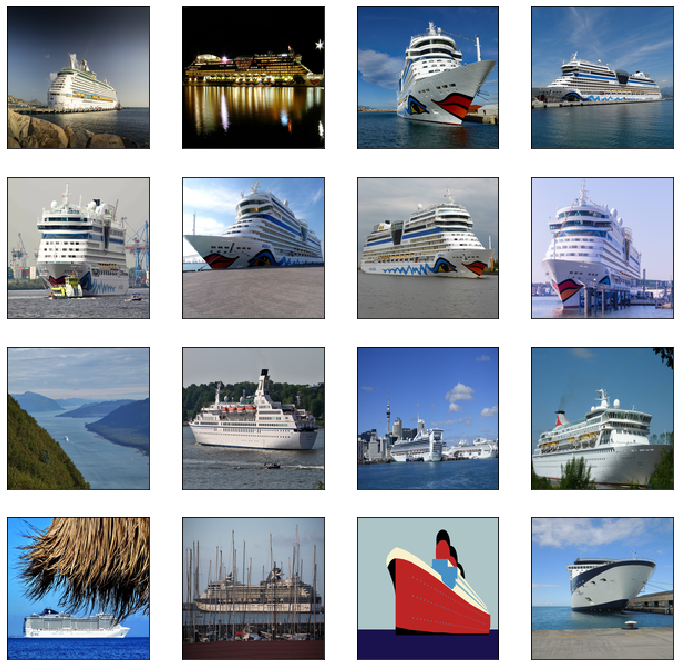

In [32]:
plt.close('all')
plt.figure(figsize=(12, 12))

for i in range(16):
  # Plot the images in a 4x4 grid
  plt.subplot(4, 4, i+1)

  # Plot image [i]
  plt.imshow(X[i])
  
  # Turn off axis lines
  cur_axes = plt.gca()
  cur_axes.axes.get_xaxis().set_visible(False)
  cur_axes.axes.get_yaxis().set_visible(False)

In [33]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping

In [34]:
import keras.backend as K
def load_CNN(output_size):
  K.clear_session()
  model = Sequential()
  model.add(Conv2D(128, (5, 5),
               input_shape=(128, 128, 3),
               activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  #model.add(BatchNormalization())

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  #model.add(BatchNormalization())

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  #model.add(BatchNormalization())

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(output_size, activation='softmax'))
  return model

In [35]:
early_stop_loss = EarlyStopping(monitor='loss', patience=3, verbose=1)
early_stop_val_acc = EarlyStopping(monitor='val_acc', patience=3, verbose=1)
model_callbacks=[early_stop_loss, early_stop_val_acc]

In [36]:
from sklearn.model_selection import train_test_split

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.layers import Activation, Dense
from keras.utils.np_utils import to_categorical

from keras.optimizers import SGD, Adam, Adagrad, RMSprop

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2)
print("The model has " + str(len(X_train)) + " inputs")

The model has 1168 inputs


In [38]:
model = load_CNN(len(boat_types))

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 124, 124, 128)     9728      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
__________

In [40]:
print("compiling~")
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0005),
              metrics=['accuracy'])

weights = model.get_weights()

compiling~


In [ ]:
batch_sizes = [16]  #, 8, 16, 32, 64, 128
print("-----")
histories_acc = []
histories_val = []
for batch_size in batch_sizes:
  print("batch_size : ", batch_size)
  model.set_weights(weights)
  h = model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=25,
                verbose=0,
                callbacks=[early_stop_loss],
                shuffle=True,
                validation_data=(X_test, y_test))

  histories_acc.append(h.history['acc'])
  histories_val.append(h.history['val_acc'])
histories_acc = np.array(histories_acc)
histories_val = np.array(histories_val)

-----
batch_size :  16


In [41]:
learning_rates = [0.0005] #0.01, 0.005, 0.001, 0.0005, 0.0001
lrsHistories_acc = []
lrsHistories_val = []
for lr in learning_rates:
    print(lr)
    model=load_CNN(len(boat_types))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=lr),
                  metrics=['accuracy'])
    h = model.fit(X_train, y_train, 
                  batch_size=16, 
                  epochs=25, 
                  verbose=1, 
                  callbacks=[early_stop_loss],
                  shuffle=True,
                  validation_data=(X_test, y_test))

    lrsHistories_acc.append(h.history['acc'])
    lrsHistories_val.append(h.history['val_acc'])
lrsHistories_acc = np.array(lrsHistories_acc)
lrsHistories_val = np.array(lrsHistories_val)

0.0005
Train on 1168 samples, validate on 292 samples
Epoch 1/25
1168/1168 [==============================] - 100s 85ms/step - loss: 0.3060 - acc: 0.8875 - val_loss: 0.2877 - val_acc: 0.8896
Epoch 2/25
1168/1168 [==============================] - 101s 87ms/step - loss: 0.2851 - acc: 0.8920 - val_loss: 0.2583 - val_acc: 0.8999
Epoch 3/25
1168/1168 [==============================] - 97s 83ms/step - loss: 0.2511 - acc: 0.9019 - val_loss: 0.2499 - val_acc: 0.9106
Epoch 4/25
1168/1168 [==============================] - 99s 84ms/step - loss: 0.2284 - acc: 0.9120 - val_loss: 0.2560 - val_acc: 0.9098
Epoch 5/25
1168/1168 [==============================] - 91s 78ms/step - loss: 0.2030 - acc: 0.9202 - val_loss: 0.2407 - val_acc: 0.9182
Epoch 6/25
1168/1168 [==============================] - 96s 82ms/step - loss: 0.1729 - acc: 0.9320 - val_loss: 0.2583 - val_acc: 0.9151
Epoch 7/25
1168/1168 [==============================] - 100s 85ms/step - loss: 0.1431 - acc: 0.9424 - val_loss: 0.2900 - val_acc

In [27]:
optimizers = ['SGD(lr=0.0001)',
              'SGD(lr=0.0001, momentum=0.3)',
              'SGD(lr=0.0001, momentum=0.3, nesterov=True)',  
              'Adam(lr=0.0001)',
              'Adagrad(lr=0.0001)',
              'RMSprop(lr=0.0001)']

optimizeList_acc = []
optimizeList_val = []

# for opt_name in optimizers:
opt_name = optimizers[3]
print("heyyyyy")
model=load_CNN(2)

model.compile(loss='binary_crossentropy',
              optimizer=eval(opt_name),
              metrics=['accuracy'])
h = model.fit(X_train, y_train, 
              batch_size=16, 
              epochs=25, 
              verbose=0, 
              callbacks=[early_stop_loss],
              shuffle=True,
              validation_data=(X_test, y_test))

optimizeList_acc.append(h.history['acc'])
optimizeList_val.append(h.history['val_acc'])
    
optimizeList_acc = np.array(optimizeList_acc)
optimizeList_val = np.array(optimizeList_val)

heyyyyy


In [28]:
import random
image_number = random.randint(0,len(X_train))
print(image_number)

240
